In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%tensorflow_version 2.x
from importlib.machinery import SourceFileLoader
somemodule = SourceFileLoader('tcn', '/content/drive/MyDrive/Sriptie/RUL-prediction/keras-tcn-master/tcn/tcn.py').load_module()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding
from sklearn import preprocessing

import os
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers.core import Activation
from tensorflow.keras.models import Sequential,load_model, model_from_json

from tcn import TCN

In [5]:
# define paths
output_path = '/content/drive/MyDrive/Sriptie/RUL-prediction/output-tcn-2-0-4'
model_path = output_path+'/mode.h5'

data_path = '/content/drive/MyDrive/Sriptie/RUL-prediction/Data/CMAPSSData/'

  

In [12]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(data_path+'train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(data_path+'test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv(data_path+'RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [13]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


In [22]:
######
# TEST set
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)


   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5  ...       s13       s14       s15  s16       s17  s18  s19       s20  \
0  0.0  ...  0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0  0.558140   
1  0.0  ...  0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0  0.682171   
2  0.0  ...  0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0  0.728682   
3  0.0  ...  0.250000  0.170090  0.257022  0.0  0.250000  0.0  0.0  0.666667   
4  0.0  ...  0.220588  0.152751  0.300885  0.0  0.166667  0.0  0.0  0.658915   

        s21  cycle_norm  
0  0.6

In [8]:
# pick a  window size 
sequence_length = 64

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

128
(14231, 64, 25)


(14231, 1)

In [ ]:

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
        
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [18]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=1000)
model.fit(train_df, y)

RandomForestRegressor(n_estimators=1000)

In [15]:
y = train_df.pop("RUL")


In [24]:
y_test = test_df.pop("RUL")

In [25]:
model.score(test_df, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.15768088002782965

In [28]:
from sklearn.neighbors import KNeighborsRegressor
k_nn = KNeighborsRegressor()
k_nn.fit(train_df, y)
k_nn.score(test_df, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.12008537637982952

In [29]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(train_df, y)
reg.score(test_df, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0.44265754331404505

In [ ]:
##output tcn2
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]


i = Input(shape=(sequence_length, nb_features))
#m = TCN()(i)
#m = Dense(1, activation='linear')(m)

m = TCN(nb_filters=32,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=True)(i)
m = TCN(nb_filters=16,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=False)(m)
m = Dense(1, activation='linear')(m)
model = Model(inputs=[i], outputs=[m])


model.summary()

model.compile('adam', 'mae')
#model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
model.compile(loss=root_mean_squared_error, optimizer='rmsprop',metrics=['mae',r2_keras,root_mean_squared_error])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 25)]          0         
_________________________________________________________________
tcn_2 (TCN)                  (None, 64, 32)            31072     
_________________________________________________________________
tcn_3 (TCN)                  (None, 16)                8224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 39,313
Trainable params: 39,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(seq_array, label_array, epochs=150, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

Train on 13519 samples, validate on 712 samples
Epoch 1/150
13519/13519 - 29s - loss: 94.7073 - mae: 72.3003 - r2_keras: -8.9942e+00 - root_mean_squared_error: 94.4679 - val_loss: 50.6923 - val_mae: 41.9951 - val_r2_keras: -3.0125e-01 - val_root_mean_squared_error: 48.6217
Epoch 2/150
13519/13519 - 22s - loss: 45.6654 - mae: 34.2175 - r2_keras: 0.2804 - root_mean_squared_error: 45.6208 - val_loss: 33.8567 - val_mae: 30.4781 - val_r2_keras: 0.4532 - val_root_mean_squared_error: 31.0320
Epoch 3/150
13519/13519 - 22s - loss: 40.6498 - mae: 29.4595 - r2_keras: 0.4285 - root_mean_squared_error: 40.6125 - val_loss: 37.3528 - val_mae: 31.4977 - val_r2_keras: 0.2370 - val_root_mean_squared_error: 35.6574
Epoch 4/150
13519/13519 - 21s - loss: 36.9566 - mae: 26.3257 - r2_keras: 0.5263 - root_mean_squared_error: 36.9521 - val_loss: 35.6862 - val_mae: 30.0522 - val_r2_keras: 0.2730 - val_root_mean_squared_error: 34.5507
Epoch 5/150
13519/13519 - 22s - loss: 34.4825 - mae: 24.2693 - r2_keras: 0.588

dict_keys(['loss', 'mae', 'r2_keras', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_r2_keras', 'val_root_mean_squared_error'])


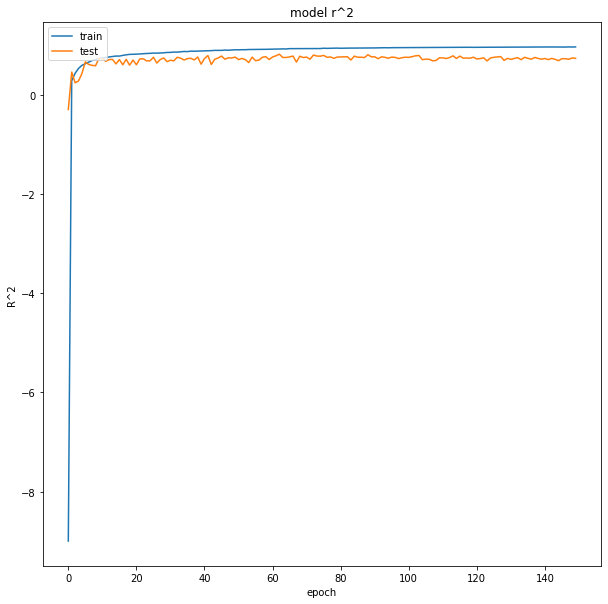

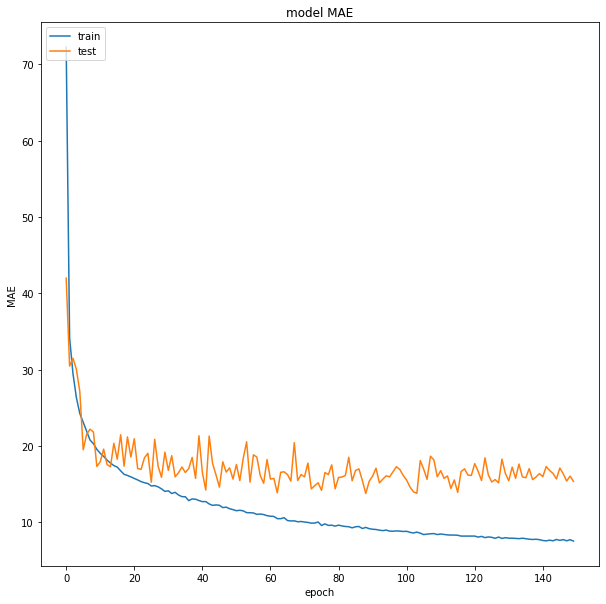

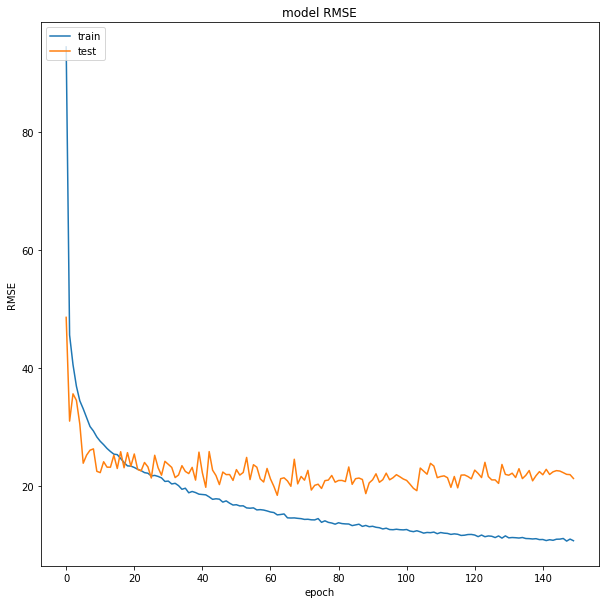

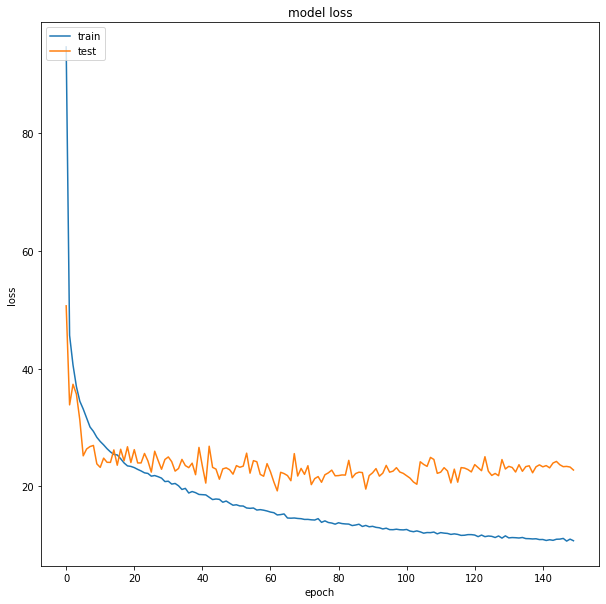

14231/14231 [==============================] - 7s 500us/sample - loss: 10.2483 - mae: 7.7372 - r2_keras: 0.9402 - root_mean_squared_error: 10.1604

MAE: 7.737183570861816

R^2: 0.9401552677154541

RMSE: 10.160378456115723
14231/14231 [==============================] - 8s 534us/sample


In [ ]:

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_mae.png")


# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
print('\nRMSE: {}'.format(scores[3]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv(output_path+'/submit_train.csv', index = None)


seq_array_test_last
(88, 64, 25)
(88, 1)
88/88 - 1s - loss: 18.5902 - mae: 13.3924 - r2_keras: 0.7934 - root_mean_squared_error: 18.6588

MAE: 13.392376899719238

R^2: 0.793411910533905

RMSE: 18.658845901489258


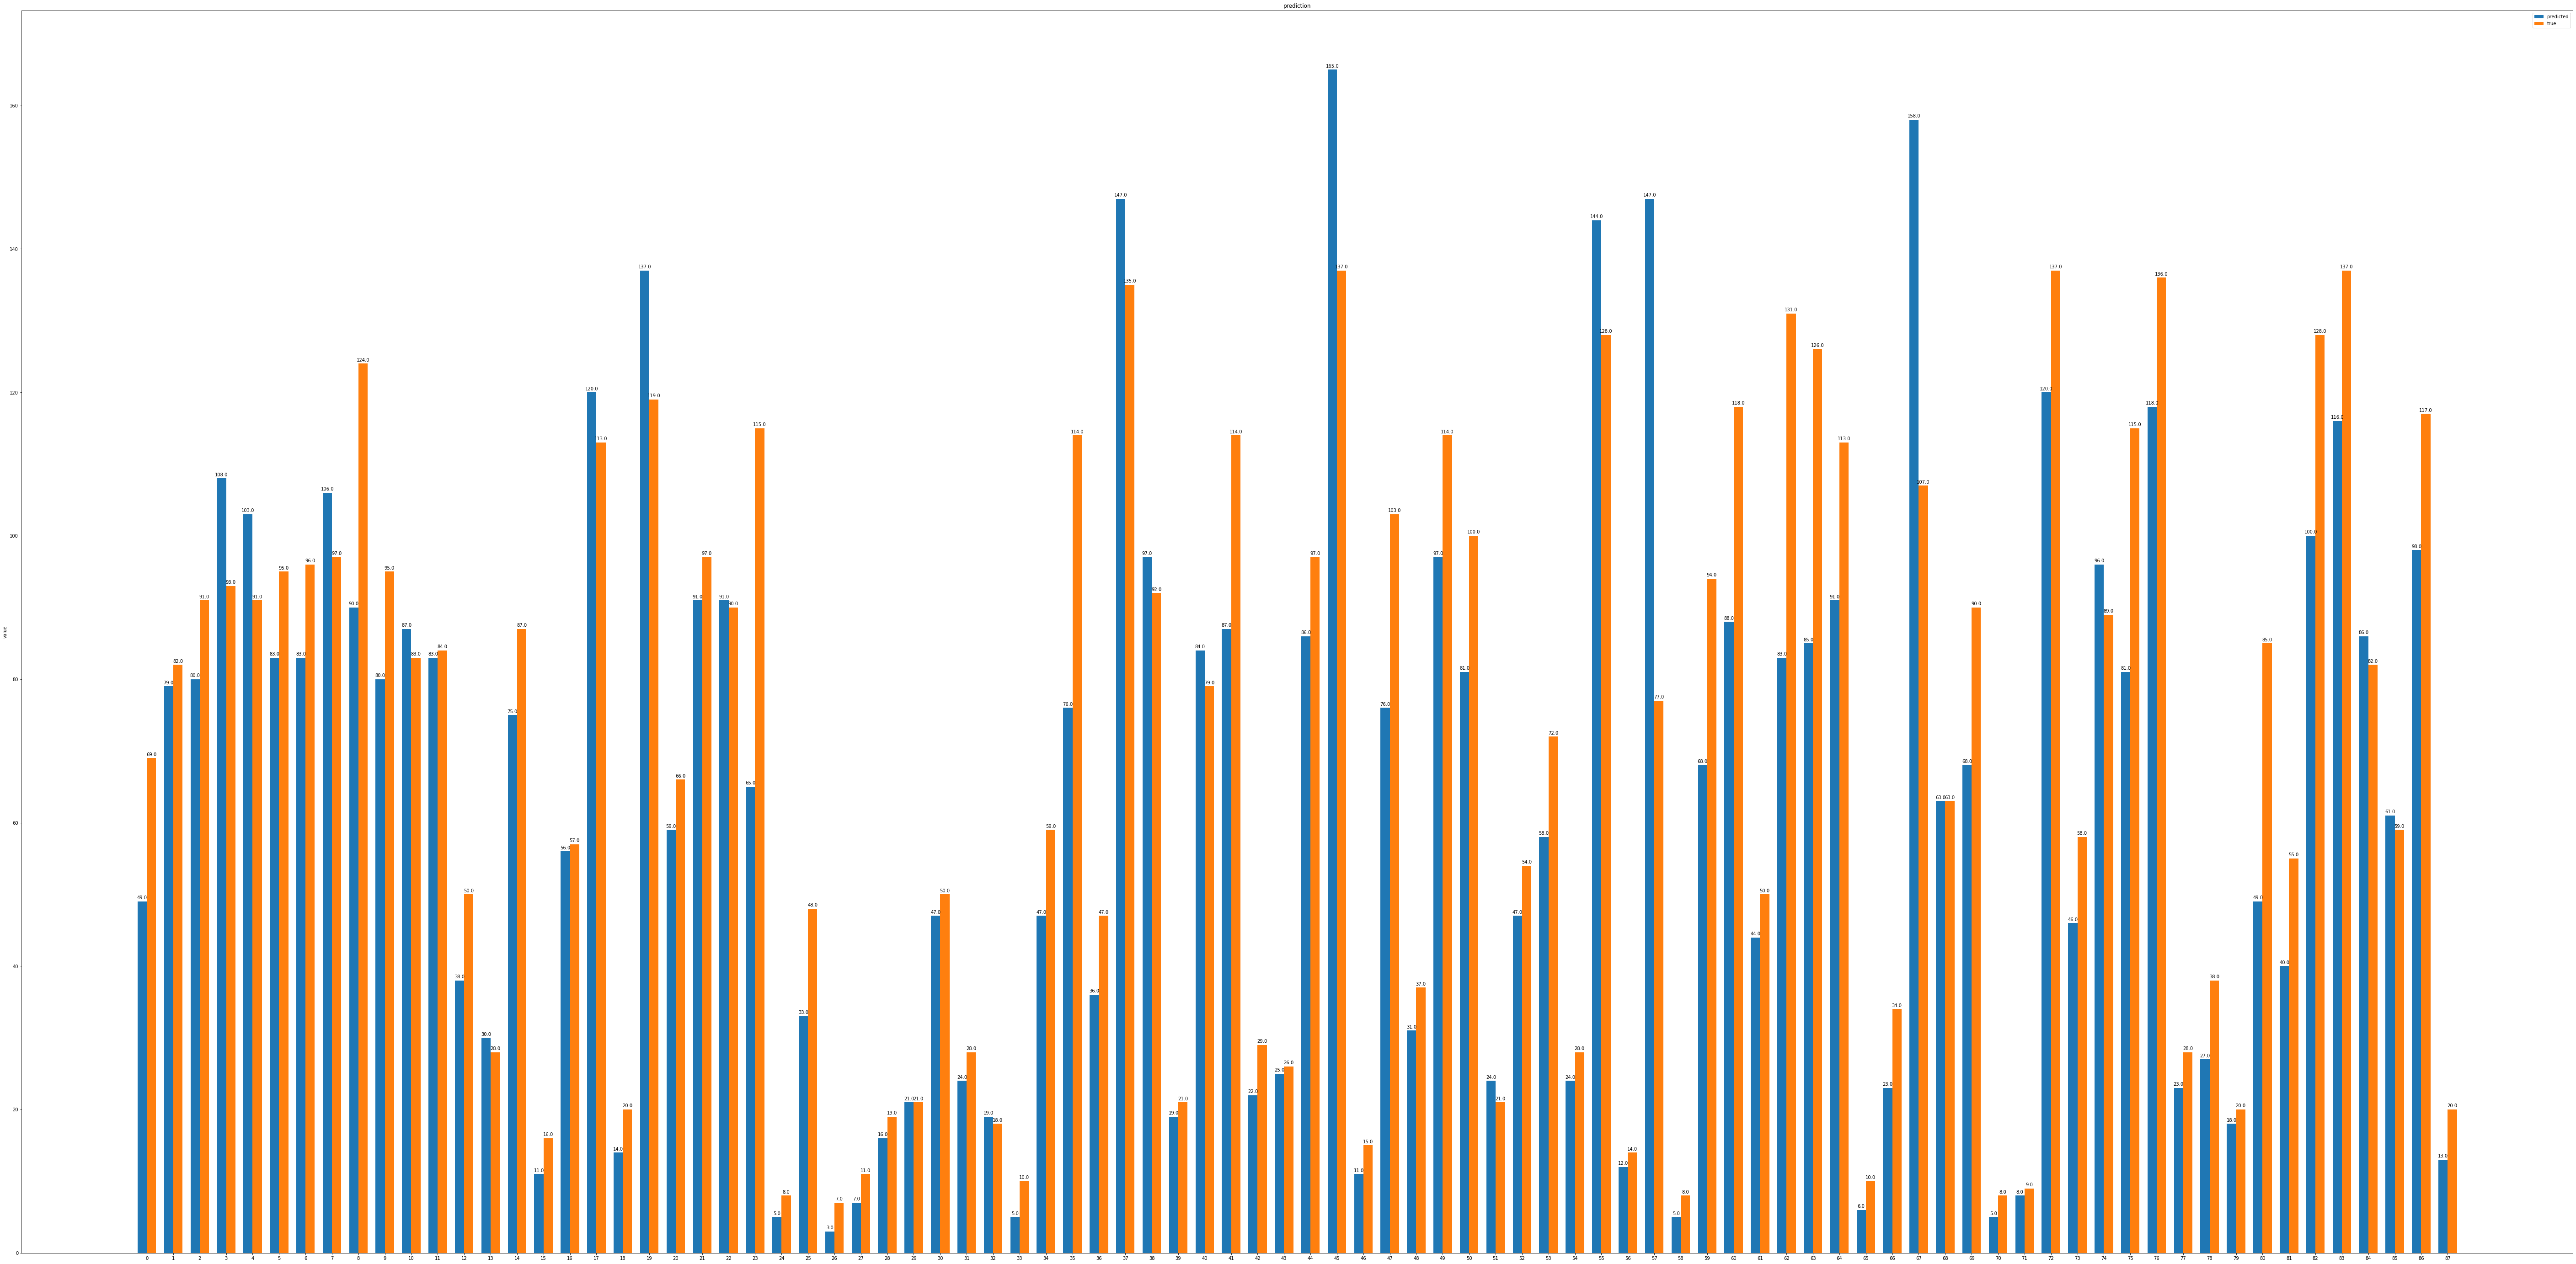

In [ ]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):

    # restore weights
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras, 'root_mean_squared_error': root_mean_squared_error,'TCN': TCN})

    
    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))
    print('\nRMSE: {}'.format(scores_test[3]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv(output_path+'/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in orange color the
    # actual data to verify visually the accuracy of the model.
        
    x = np.arange(len(y_pred_test))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(100, 50))
    rects1 = ax.bar(x - width/2, y_pred_test.flatten().round(), width, label='predicted')
    rects2 = ax.bar(x + width/2, y_true_test.flatten(), width, label='true')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('value')
    ax.set_title('prediction')
    ax.set_xticks(x)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    plt.show()
    fig.savefig(output_path+"/model_verify_bar.png")